In [ ]:
"""
train_gnn_only.py

Train a GNN autoencoder on spatial dataset A only to test whether
the GNN can learn meaningful latent embeddings for xenium_spatial.

Outputs:
 - gnn_only.pt         (model state_dict)
 - z_spatial_gnn.npy   (learned latent embeddings)
 - gnn_recon_loss.csv  (per-epoch recon loss)
 - embeddings_umap_gnn.png, embeddings_pca_gnn.png (visuals)
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import umap
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import random

In [109]:
# --------------------------
# === CONFIG / HYPERS ======
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)

# hyperparams
knn_k = 6
latent_dim = 32
hidden_dim = 128
warmup_epochs = 150           # train GAE alone first
total_epochs = 800
lr = 1e-3
neg_pos_ratio = 1
alpha = 1.0                   # weight for clustering KL loss
n_clusters = 6                # desired # clusters for DEC-style refinement
update_interval = 20          # every how many epochs to recompute Q/P and cluster centers
tol = 1e-3                    # stop if cluster assignment change < tol fraction



In [110]:
# --------------------------
# === HELPERS ============
# --------------------------
def build_knn_edges(coords_torch, k=8):
    n = coords_torch.size(0)
    dists = torch.cdist(coords_torch, coords_torch, p=2.0)
    dists.fill_diagonal_(float('inf'))
    knn_idx = torch.topk(dists, k=k, largest=False).indices
    edges_set = set()
    for u in range(n):
        for v in knn_idx[u].tolist():
            a, b = (u, v) if u < v else (v, u)
            edges_set.add((a, b))
    edges = sorted(list(edges_set))
    if len(edges) == 0:
        return torch.empty((0,2), dtype=torch.long)
    return torch.tensor(edges, dtype=torch.long)

def normalize_adj_dense(A):
    n = A.size(0)
    A_hat = A + torch.eye(n, device=A.device)
    deg = A_hat.sum(dim=1)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[torch.isinf(deg_inv_sqrt)] = 0.0
    D_inv_sqrt = torch.diag(deg_inv_sqrt)
    return D_inv_sqrt @ A_hat @ D_inv_sqrt

def negative_sampling(num_nodes, pos_edges_set, num_samples):
    negs = []
    tries = 0
    while len(negs) < num_samples and tries < num_samples * 10:
        u = random.randrange(num_nodes); v = random.randrange(num_nodes)
        if u == v:
            tries += 1; continue
        a, b = (u, v) if u < v else (v, u)
        if (a, b) in pos_edges_set:
            tries += 1; continue
        negs.append((a, b)); tries += 1
    if len(negs) < num_samples:
        for i in range(num_nodes):
            for j in range(i+1, num_nodes):
                if (i,j) not in pos_edges_set:
                    negs.append((i,j))
                    if len(negs) >= num_samples:
                        break
            if len(negs) >= num_samples: break
    return torch.tensor(negs[:num_samples], dtype=torch.long)


In [111]:
# --------------------------
# === MODEL ===============
# --------------------------
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim, bias=True)
    def forward(self, X, A_norm):
        return F.relu(self.linear(A_norm @ X))

class GCNEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, latent_dim):
        super().__init__()
        self.gcn1 = GCNLayer(in_dim, hidden_dim)
        self.gcn2 = GCNLayer(hidden_dim, latent_dim)
    def forward(self, X, A_norm):
        h = self.gcn1(X, A_norm)
        z = self.gcn2(h, A_norm)  # (n, latent_dim)
        return z


In [112]:
# ---------- DEC-style soft assignment ----------
def q_student_t(Z, cluster_centers, eps=1e-12):
    # Z: (n,d), cluster_centers: (k,d)
    # returns Q_ij proportional to (1 + ||z_i - mu_j||^2 / v)^(-(v+1)/2)
    # use v=1 => q_ij = (1 + ||z-mu||^2)^-1 normalized across clusters
    n, d = Z.shape
    k = cluster_centers.shape[0]
    # compute pairwise squared distances
    # (n,1,d) - (1,k,d) -> (n,k,d)
    Z_exp = Z.unsqueeze(1)  # (n,1,d)
    C_exp = cluster_centers.unsqueeze(0)  # (1,k,d)
    dist2 = torch.sum((Z_exp - C_exp)**2, dim=2)  # (n,k)
    q = 1.0 / (1.0 + dist2)  # numerator
    q = q / torch.sum(q, dim=1, keepdim=True)  # normalize per sample
    return q + eps

def target_distribution(q):
    # q: (n,k)
    weight = (q ** 2) / torch.sum(q, dim=0, keepdim=True)
    p = (weight.t() / torch.sum(weight, dim=1)).t()
    return p

In [113]:
# ---------------------------
# Data loading & preprocessing
# ---------------------------
def load_and_preprocess(spat_path="SmallData/xenium_spatial_common_genes.h5ad"):
    # load
    A = sc.read_h5ad(spat_path)

    # Prefer obs column with broad labels (user should have created 'broad_cell_type' earlier)
    possible_spat_cols = ["broad_cell_type", "cell_type", "predicted_label"]
    spat_label_col = next((c for c in possible_spat_cols if c in A.obs.columns), None)

    if spat_label_col is None:
        print("Warning: spatial label column not found. Spatial labels will be None (can't compute test acc).")

    # Normalize total and log1p (inplace on copies)

    Ac = A.copy()
    sc.pp.normalize_total(Ac, target_sum=1e4)
    sc.pp.log1p(Ac)

    # Convert to dense arrays (small 2k dataset assumed)
    X_spat = Ac.X.toarray() if hasattr(Ac.X, "toarray") else Ac.X

    # labels
    y_spat = Ac.obs[spat_label_col].astype(str).values if spat_label_col in Ac.obs.columns else None

    # map labels to ints
    all_labels = np.unique(y_spat)
    label_to_id = {lab: i for i, lab in enumerate(all_labels)}
    y_spat_id = np.array([label_to_id[l] for l in y_spat]) if y_spat is not None else None

    # spatial coords
    if "spatial" not in Ac.obsm_keys():
        raise RuntimeError("Spatial coords key 'spatial' not found in A.obsm.")
    coords = Ac.obsm["spatial"]

    return (label_to_id, X_spat.astype(np.float32), y_spat_id, Ac.obs_names.values, coords, all_labels)

In [114]:
## Loading the data
label_to_id, X_spat, y_spat, spat_ids, coords, all_labels = load_and_preprocess(
         spat_path="SmallData/xenium_spatial_common_genes.h5ad"
    )

/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


In [115]:
# --------------------------
# === TRAINING FUNCTION ====
# --------------------------
def train_unsupervised_cluster_gae(X_np, coords_np):
    X = torch.from_numpy(X_np).to(device)
    coords = torch.from_numpy(coords_np).to(device)
    n = X.shape[0]
    edges = build_knn_edges(coords, k=knn_k).to(device)
    pos_edge_set = set([(int(u), int(v)) for u,v in edges.tolist()])
    A = torch.zeros((n, n), device=device)
    if edges.numel()>0:
        A[edges[:,0], edges[:,1]] = 1.0
        A[edges[:,1], edges[:,0]] = 1.0
    A_norm = normalize_adj_dense(A)
    model = GCNEncoder(in_dim=X.shape[1], hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    bce_logits = nn.BCEWithLogitsLoss()
    pos_u = edges[:,0] if edges.numel()>0 else torch.tensor([], dtype=torch.long, device=device)
    pos_v = edges[:,1] if edges.numel()>0 else torch.tensor([], dtype=torch.long, device=device)
    num_pos = pos_u.size(0) if edges.numel()>0 else 0

    # warm-up: train only on adjacency for some epochs
    for epoch in range(1, warmup_epochs+1):
        model.train(); opt.zero_grad()
        Z = model(X, A_norm)                   # (n,latent)
        logits = Z @ Z.t()
        # negative sampling
        if num_pos > 0:
            num_neg = int(num_pos * neg_pos_ratio)
            neg_edges = negative_sampling(n, pos_edge_set, num_neg).to(device)
            neg_u = neg_edges[:,0]; neg_v = neg_edges[:,1]
            pos_logits = logits[pos_u, pos_v]
            neg_logits = logits[neg_u, neg_v]
            all_logits = torch.cat([pos_logits, neg_logits], dim=0)
            targets = torch.cat([torch.ones_like(pos_logits), torch.zeros_like(neg_logits)], dim=0)
            loss = bce_logits(all_logits, targets)
        else:
            # fallback (no edges) -> tiny loss
            loss = torch.tensor(0.0, device=device)

        loss.backward(); opt.step()
        if epoch % 50 == 0 or epoch==1:
            print(f"[warmup] epoch {epoch}/{warmup_epochs} loss {loss.item():.4f}")

    # --- initialize clusters from KMeans on embeddings ---
    model.eval()
    with torch.no_grad():
        Z_init = model(X, A_norm).cpu().numpy()
    kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=seed).fit(Z_init)
    cluster_centers = torch.from_numpy(kmeans.cluster_centers_.astype(np.float32)).to(device)

    # training with KL clustering loss + adjacency recon
    prev_assignment = kmeans.labels_
    for epoch in range(warmup_epochs+1, total_epochs+1):
        model.train(); opt.zero_grad()
        Z = model(X, A_norm)                   # (n,latent)
        logits = Z @ Z.t()

        # adjacency loss via sampled pairs (same as before)
        if num_pos > 0:
            num_neg = int(num_pos * neg_pos_ratio)
            neg_edges = negative_sampling(n, pos_edge_set, num_neg).to(device)
            neg_u = neg_edges[:,0]; neg_v = neg_edges[:,1]
            pos_logits = logits[pos_u, pos_v]
            neg_logits = logits[neg_u, neg_v]
            all_logits = torch.cat([pos_logits, neg_logits], dim=0)
            targets = torch.cat([torch.ones_like(pos_logits), torch.zeros_like(neg_logits)], dim=0)
            loss_adj = bce_logits(all_logits, targets)
        else:
            loss_adj = torch.tensor(0.0, device=device)

        # clustering loss (compute Q, P occasionally)
        if epoch % update_interval == 0 or epoch == warmup_epochs+1:
            model.eval()
            with torch.no_grad():
                Z_cpu = model(X, A_norm).cpu()
                # recompute cluster centers via KMeans on latest Z
                kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=seed).fit(Z_cpu.numpy())
                cluster_centers = torch.from_numpy(kmeans.cluster_centers_.astype(np.float32)).to(device)
                # compute q and p (full)
                q = q_student_t(Z_cpu.to(device), cluster_centers)  # (n,k)
                p = target_distribution(q)
                # get new hard assignments for monitoring
                new_assign = kmeans.labels_
            model.train()
            # monitor assignment change
            changed = np.mean(prev_assignment != new_assign)
            print(f"[epoch {epoch}] KMeans assignment change fraction: {changed:.4f}")
            prev_assignment = new_assign
            if changed < tol:
                print("Converged cluster assignments (change below tol). Breaking.")
                break
        # compute q (current) for KL loss
        q_curr = q_student_t(Z, cluster_centers)  # (n,k)
        # ensure p available; compute p from last recomputation
        # we computed p in the block above; if not computed yet (rare), build from q_curr
        if 'p' not in locals():
            p = target_distribution(q_curr.detach())
        # clustering KL loss: KL(P || Q) = sum p * log(p/q)
        eps = 1e-10
        loss_kl = torch.sum(p.to(device) * torch.log((p.to(device) + eps) / (q_curr + eps))) / n

        loss = loss_adj + alpha * loss_kl
        loss.backward(); opt.step()

        if epoch % 50 == 0 or epoch==warmup_epochs+1:
            print(f"Epoch {epoch}/{total_epochs} | loss {loss.item():.4f} | loss_adj {loss_adj.item():.4f} | loss_kl {loss_kl.item():.6f}")

    # final embeddings
    model.eval()
    with torch.no_grad():
        Z_final = model(X, A_norm).cpu().numpy()
    return Z_final

In [116]:
# hyperparams
knn_k = 6
latent_dim = 32
hidden_dim = 128
warmup_epochs = 1000           # train GAE alone first
total_epochs = 800
lr = 1e-3
neg_pos_ratio = 1
alpha = 10                   # weight for clustering KL loss
n_clusters = len(np.unique(y_spat))   # desired # clusters for DEC-style refinement
update_interval = 20          # every how many epochs to recompute Q/P and cluster centers
tol = 1e-3                    # stop if cluster assignment change < tol fraction


Z = train_unsupervised_cluster_gae(X_spat, coords)
print("Learned embeddings Z shape:", Z.shape)

[warmup] epoch 1/1000 loss 1.6100
[warmup] epoch 50/1000 loss 0.6051
[warmup] epoch 100/1000 loss 0.5630
[warmup] epoch 150/1000 loss 0.5269
[warmup] epoch 200/1000 loss 0.5033
[warmup] epoch 250/1000 loss 0.4850
[warmup] epoch 300/1000 loss 0.4723
[warmup] epoch 350/1000 loss 0.4687
[warmup] epoch 400/1000 loss 0.4649
[warmup] epoch 450/1000 loss 0.4615
[warmup] epoch 500/1000 loss 0.4545
[warmup] epoch 550/1000 loss 0.4541
[warmup] epoch 600/1000 loss 0.4462
[warmup] epoch 650/1000 loss 0.4462
[warmup] epoch 700/1000 loss 0.4420
[warmup] epoch 750/1000 loss 0.4434
[warmup] epoch 800/1000 loss 0.4364
[warmup] epoch 850/1000 loss 0.4381
[warmup] epoch 900/1000 loss 0.4330
[warmup] epoch 950/1000 loss 0.4395
[warmup] epoch 1000/1000 loss 0.4436
Learned embeddings Z shape: (2000, 32)


## Model Evaluation

In [117]:
# ---- Parameters (tweak as needed) ----
n_neighbors = 32     # UMAP param: affects local vs global structure
min_dist = 0.9       # UMAP param: tightness of clusters
n_components = 2
random_state = 42

# ---- Run UMAP ----
reducer = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=random_state
)
Z_umap = reducer.fit_transform(Z)  # (n, 2)
print("UMAP done; result shape:", Z_umap.shape)


/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP done; result shape: (2000, 2)


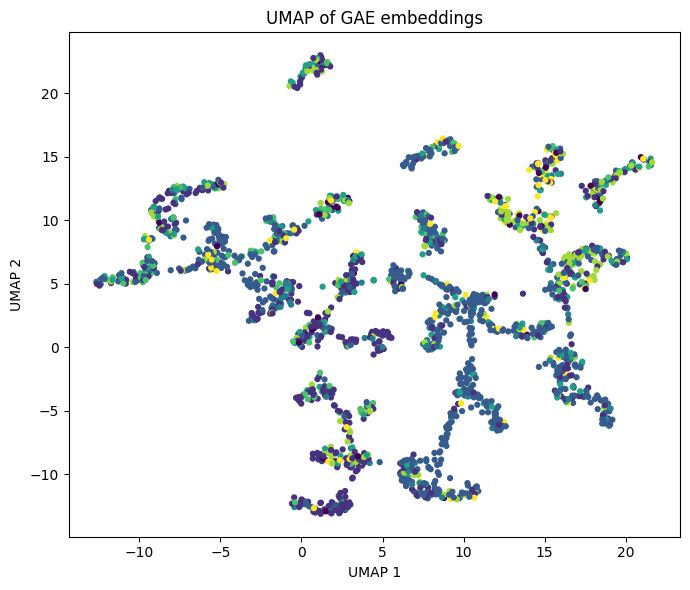

In [118]:
# ---- Plotting ----
plt.figure(figsize=(7,6))

plt.scatter(Z_umap[:,0], Z_umap[:,1], c=y_spat, s=12)
plt.title("UMAP of GAE embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

## Other Diagnostics 

In [119]:
X_1 = torch.from_numpy(X_spat).to(device)
coords_1 = torch.from_numpy(coords).to(device)
n = X_1.shape[0]
edges = build_knn_edges(coords_1, k=knn_k).to(device)
pos_edge_set = set([(int(u), int(v)) for u,v in edges.tolist()])
A = torch.zeros((n, n), device=device)
if edges.numel()>0:
    A[edges[:,0], edges[:,1]] = 1.0
    A[edges[:,1], edges[:,0]] = 1.0
A_norm = normalize_adj_dense(A)

Nodes: 2000 Edges (undirected): 7274 avg deg: 7.274


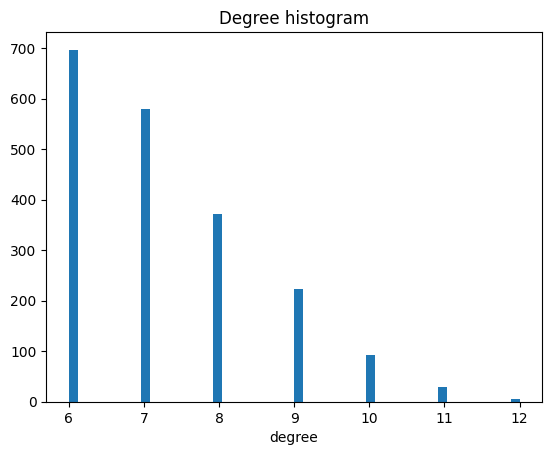

In [120]:
from collections import Counter

# Provide your adjacency matrix A (dense torch tensor) or rebuild from your edges
# If you have edges in variable `edges` shape (m,2) use:
# n = X_np.shape[0]
# A = np.zeros((n,n))
# A[edges[:,0], edges[:,1]] = 1; A[edges[:,1], edges[:,0]]=1

# if A exists as torch tensor:
A_torch = A if isinstance(A, torch.Tensor) else torch.from_numpy(A.astype(float))
n = A_torch.shape[0]
m = int(A_torch.sum().item() / 2)
deg = A_torch.sum(dim=1).cpu().numpy()
print("Nodes:", n, "Edges (undirected):", m, "avg deg:", deg.mean())
# degree histogram
plt.hist(deg, bins=50)
plt.title("Degree histogram"); plt.xlabel("degree"); plt.show()


In [122]:
from sklearn.metrics import roc_auc_score, average_precision_score
# Z: numpy (n,d) or torch
Z_t = torch.from_numpy(Z).float() if isinstance(Z, np.ndarray) else Z.float()
logits = (Z_t @ Z_t.t()).cpu().numpy()  # dot-product logits
probs = 1 / (1 + np.exp(-logits))

# get upper-triangular pos/neg lists (avoid self)
n = Z_t.size(0)
triu_idx = np.triu_indices(n, k=1)
A_np = A_torch.cpu().numpy()
y_true = A_np[triu_idx]
y_score = probs[triu_idx]

# compute metrics
auc = roc_auc_score(y_true, y_score)
ap = average_precision_score(y_true, y_score)
print("Adjacency reconstruction AUC:", auc, "AP:", ap)


Adjacency reconstruction AUC: 0.9815498416495372 AP: 0.1354521932749066
